# Project 2 - Film Analysis

By Jared Lilly \
Instructor Mark Barbour \
Flatiron School

## Business problem
Three suggestions for getting into original video content for a new movie studio department. I have been tasked with finding characteristics of films that are doing best. We will explore when these films are released, the production budget of successful films and which genres have the highest average gross return
### Defining Success
For the purpose of this analysis we are leaning on IMDB's definition of a successful film found in the article [How is the success of films and TV shows measured?](https://pro.imdb.com/content/article/entertainment-industry-resources/featured-articles/how-is-the-success-of-films-and-tv-shows-measured/GLFTC8ZLBBUSNTM3), which defines a successful film as a movie that makes twice as much as it's production budget to account for distribution costs. Some studies have increased the limit to 2.5x the production budget, however, for our purposes we'll stick with defining success as movies that made 2x their production budget.

### The Data
* Taken from datasets collected by IMDB, Box Office Mojo, and The Numbers
* Includes information about movies including production budget, domestic and international gross, directors, genres, etc. 

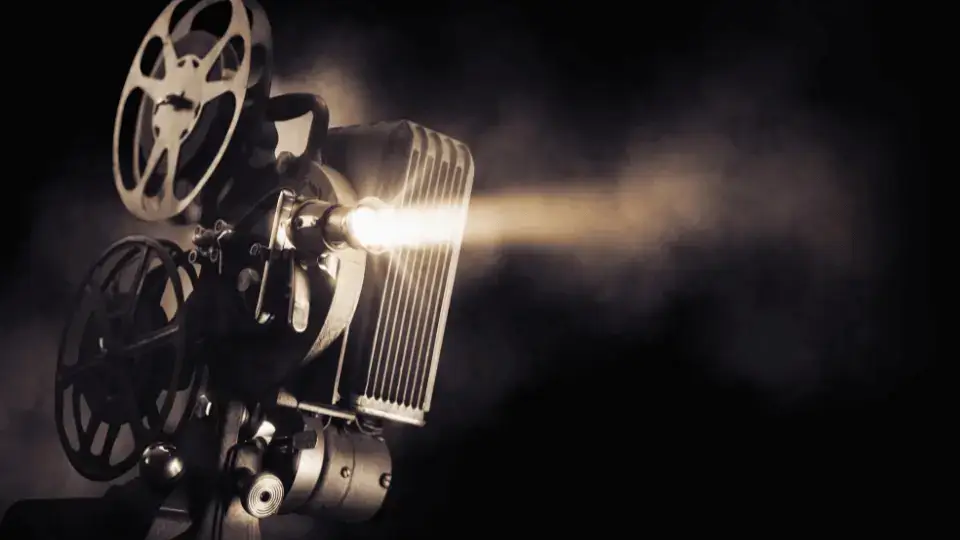

### Data Exploration
* Loaded in libraries and all datasets
* Basic data exploration to familiarize with data
* Combined datasets to check for correlations

In [2]:
#Loading in libraries and datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import sqlite3
import zipfile
%matplotlib inline

In [3]:
# Loaded in Box Office Mojo dataset and saved as dataframe, from looking at the data want to use studio vs gross
# and how many movies each studio makes per year
df_bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
df_bom

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [4]:
# Unzipped and extracted imdb database using an imported zipfile library
import zipfile
with zipfile.ZipFile('zippedData/im.db.zip', 'r') as zip_ref:
    zip_ref.extractall('zippedData')
conn = sqlite3.connect('zippedData/im.db')

In [5]:
# Combined two tables into a dataframe using SQL, filtered out all ratings with under 100 number of votes as imdb 
# duplicate entries
q = """
    SELECT  movie_basics.start_year, 
            movie_basics.genres, 
            movie_basics.primary_title,
            movie_basics.runtime_minutes,
            movie_basics.original_title,
            movie_ratings.averagerating, 
            movie_ratings.numvotes  
       FROM movie_basics
      JOIN movie_ratings USING(movie_id)
      WHERE movie_ratings.numvotes > 99;
    """
df_movie_rating = pd.read_sql(q, conn)
df_movie_rating

,start_year,genres,primary_title,runtime_minutes,original_title,averagerating,numvotes
0,2019,Documentary,Borderless,87.0,Borderless,8.9,559
1,2014,"Action,Adventure,Fantasy",The Legend of Hercules,99.0,The Legend of Hercules,4.2,50352
2,2010,"Comedy,Romance",Habana Eva,106.0,Habana Eva,6.2,326
3,2010,"Biography,Drama,Sport",The Hammer,108.0,Hamill,7.0,1613
4,2011,"Drama,Thriller",The Night Clerk,104.0,Avant l'aube,6.4,571
...,...,...,...,...,...,...,...
28748,2018,Drama,Sükut Evi,97.0,Sükut Evi,7.1,338
28749,2019,"Biography,Drama",PM Narendra Modi,136.0,PM Narendra Modi,3.7,4057
28750,2019,"Comedy,Romance",Ir visi ju vyrai,108.0,Ir visi ju vyrai,7.7,161
28751,2019,"Horror,Thriller",Musabbar,NaN,Musabbar,5.5,317


In [6]:
# Created new column with name to merge databases for further analysis. 
df_bom['primary_title'] = df_bom['title']
df_bom

,title,studio,domestic_gross,foreign_gross,year,primary_title
0,Toy Story 3,BV,415000000.0,652000000,2010,Toy Story 3
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010,Alice in Wonderland (2010)
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010,Harry Potter and the Deathly Hallows Part 1
3,Inception,WB,292600000.0,535700000,2010,Inception
4,Shrek Forever After,P/DW,238700000.0,513900000,2010,Shrek Forever After
...,...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018,The Quake
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018,Edward II (2018 re-release)
3384,El Pacto,Sony,2500.0,NaN,2018,El Pacto
3385,The Swan,Synergetic,2400.0,NaN,2018,The Swan


In [7]:
# Combined imdb and box office mojo dataframes using the primary_title column
df_combined = pd.merge(df_movie_rating, df_bom, on='primary_title')

In [8]:
# Dropped duplicate columns year and title
df_combined.drop(columns=['start_year','title'], inplace=True)

In [9]:
# Checking out top and bottom 5 entires, the resulting dataframe has 2762 rows and 10 columns
df_combined

,genres,primary_title,runtime_minutes,original_title,averagerating,numvotes,studio,domestic_gross,foreign_gross,year
0,"Action,Adventure,Fantasy",The Legend of Hercules,99.0,The Legend of Hercules,4.2,50352,LG/S,18800000.0,42400000,2014
1,Comedy,Baggage Claim,96.0,Baggage Claim,5.1,8296,FoxS,21600000.0,887000,2013
2,"Adventure,Animation,Drama",Jack and the Cuckoo-Clock Heart,94.0,Jack et la mécanique du coeur,7.0,5494,Shout!,NaN,3400000,2014
3,"Biography,Drama,Sport",Moneyball,133.0,Moneyball,7.6,326657,Sony,75600000.0,34600000,2011
4,"Drama,Fantasy,Romance",Hereafter,129.0,Hereafter,6.5,87288,WB,32700000.0,72500000,2010
...,...,...,...,...,...,...,...,...,...,...
2757,"Action,Adventure",The Dead Lands,107.0,The Dead Lands,6.3,4185,Magn.,5200.0,NaN,2015
2758,"Action,Drama,Thriller",The Wave,105.0,Bølgen,6.7,28167,Magn.,177000.0,NaN,2016
2759,Documentary,Hitchcock/Truffaut,79.0,Hitchcock/Truffaut,7.4,4977,Cohen,260000.0,NaN,2015
2760,"Biography,Drama",Boy Erased,115.0,Boy Erased,7.0,18768,Focus,6800000.0,5000000,2018


In [10]:
# Checking data types for any that need to be converted.
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2762 entries, 0 to 2761
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   genres           2762 non-null   object 
 1   primary_title    2762 non-null   object 
 2   runtime_minutes  2758 non-null   float64
 3   original_title   2762 non-null   object 
 4   averagerating    2762 non-null   float64
 5   numvotes         2762 non-null   int64  
 6   studio           2759 non-null   object 
 7   domestic_gross   2743 non-null   float64
 8   foreign_gross    1655 non-null   object 
 9   year             2762 non-null   int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 237.4+ KB


In [11]:
# Grouped genres to check means, sorted by biggest to smallest domestic gross
df_combined.groupby('genres').mean().sort_values(by='domestic_gross', ascending=False)

,runtime_minutes,averagerating,numvotes,domestic_gross,year
genres,,,,,
"Adventure,Drama,Sport",93.000000,6.200000,62311.000000,4.007000e+08,2013.000000
"Action,Adventure,Sci-Fi",130.617021,6.776596,419616.851064,2.345681e+08,2014.085106
"Adventure,Drama,Sci-Fi",156.500000,8.300000,989725.000000,2.082000e+08,2014.500000
"Adventure,Fantasy",139.666667,7.166667,375770.333333,1.929000e+08,2013.333333
"Biography,Drama,Musical",105.000000,7.600000,199663.000000,1.743000e+08,2017.000000
...,...,...,...,...,...
"Action,Horror,Mystery",100.500000,4.750000,12217.500000,2.800000e+03,2012.500000
"Fantasy,Thriller",98.000000,5.700000,5010.000000,1.400000e+03,2018.000000
"Comedy,Thriller",132.000000,2.100000,647.000000,8.000000e+02,2014.000000


In [12]:
# There are 19 missing values for domestic gross and 1107 for foreign gross. There can be several possible reasons for the
# the missing data, a major one being that it is very possible for a film to only have a domestic release. 

print(df_combined.isna().value_counts('domestic_gross'))
print(df_combined.isna().value_counts('foreign_gross'))

domestic_gross
False    2743
True       19
dtype: int64
foreign_gross
False    1655
True     1107
dtype: int64


In [13]:
# Converted foreign gross to a float type for further analysis
df_combined['foreign_gross'] = df_combined['foreign_gross'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Converted all NaN to 0, as likely that movies were released either entirely abroad or domestically
df_combined['domestic_gross'] = df_combined['domestic_gross'].fillna(0)
df_combined['foreign_gross'] = df_combined['foreign_gross'].fillna(0)

# Created new column that combined domestic and foreign gross
df_combined['total_gross'] = df_combined['domestic_gross'] + df_combined['foreign_gross']

In [14]:
# Double-checked that non-null count and data types for foreign and total gross columns
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2762 entries, 0 to 2761
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   genres           2762 non-null   object 
 1   primary_title    2762 non-null   object 
 2   runtime_minutes  2758 non-null   float64
 3   original_title   2762 non-null   object 
 4   averagerating    2762 non-null   float64
 5   numvotes         2762 non-null   int64  
 6   studio           2759 non-null   object 
 7   domestic_gross   2762 non-null   float64
 8   foreign_gross    2762 non-null   float64
 9   year             2762 non-null   int64  
 10  total_gross      2762 non-null   float64
dtypes: float64(5), int64(2), object(4)
memory usage: 258.9+ KB


### Data Exploration and Cleaning Conclusion: 
* Imported and cleaned imdb and bom datasets  to combine into dataframe called df_combined
* Changed Data types for further analysis and checked for null values. 
* Combined foreign and domestic gross columns for total gross of each films

## Which Genres Perform Best?
* Sorted dataset by total gross to compare which film genre combos perform best
* Plotted the distribution of each genre type to see total movies made in each genre
* Plotted the gross by each genre to see which types of movies perform best 

In [15]:
# Printed the top 50 films with the highest gross worldwide
df_combined.sort_values('total_gross', ascending=False).head(50)

,genres,primary_title,runtime_minutes,original_title,averagerating,numvotes,studio,domestic_gross,foreign_gross,year,total_gross
2547,"Action,Adventure,Sci-Fi",Avengers: Age of Ultron,141.0,Avengers: Age of Ultron,7.3,665594,BV,459000000.0,946400000.0,2015,1.405400e+09
447,"Action,Adventure,Sci-Fi",Black Panther,134.0,Black Panther,7.3,516148,BV,700100000.0,646900000.0,2018,1.347000e+09
296,"Action,Adventure,Fantasy",Star Wars: The Last Jedi,152.0,Star Wars: Episode VIII - The Last Jedi,7.1,462903,BV,620200000.0,712400000.0,2017,1.332600e+09
400,"Action,Adventure,Sci-Fi",Jurassic World: Fallen Kingdom,128.0,Jurassic World: Fallen Kingdom,6.2,219125,Uni.,417700000.0,891800000.0,2018,1.309500e+09
788,"Adventure,Drama,Sport",Frozen,93.0,Frozen,6.2,62311,BV,400700000.0,875700000.0,2013,1.276400e+09
789,"Adventure,Animation,Comedy",Frozen,102.0,Frozen,7.5,516998,BV,400700000.0,875700000.0,2013,1.276400e+09
1886,"Action,Adventure,Animation",Incredibles 2,118.0,Incredibles 2,7.7,203510,BV,608600000.0,634200000.0,2018,1.242800e+09
1058,"Action,Adventure,Sci-Fi",Iron Man 3,130.0,Iron Man Three,7.2,692794,BV,409000000.0,805800000.0,2013,1.214800e+09
1677,"Adventure,Animation,Comedy",Minions,91.0,Minions,6.4,193917,Uni.,336000000.0,823400000.0,2015,1.159400e+09
2428,"Action,Adventure,Sci-Fi",Captain America: Civil War,147.0,Captain America: Civil War,7.8,583507,BV,408100000.0,745200000.0,2016,1.153300e+09


In [16]:
# Only 2 films in the top 50 did not include either Action or Adventure
# 30 of the top 50 grossing films included both action and adventure
df_combined.sort_values('total_gross', ascending=False).head(50).value_counts('genres')

genres
Action,Adventure,Sci-Fi       13
Adventure,Animation,Comedy    11
Action,Adventure,Fantasy       6
Action,Adventure,Comedy        6
Action,Adventure,Thriller      3
Adventure,Fantasy              2
Crime,Drama                    1
Biography,Drama,Music          1
Adventure,Family,Fantasy       1
Adventure,Drama,Sport          1
Action,Thriller                1
Action,Drama,Thriller          1
Action,Crime,Thriller          1
Action,Adventure,Family        1
Action,Adventure,Animation     1
dtype: int64

<Figure size 1080x720 with 0 Axes>

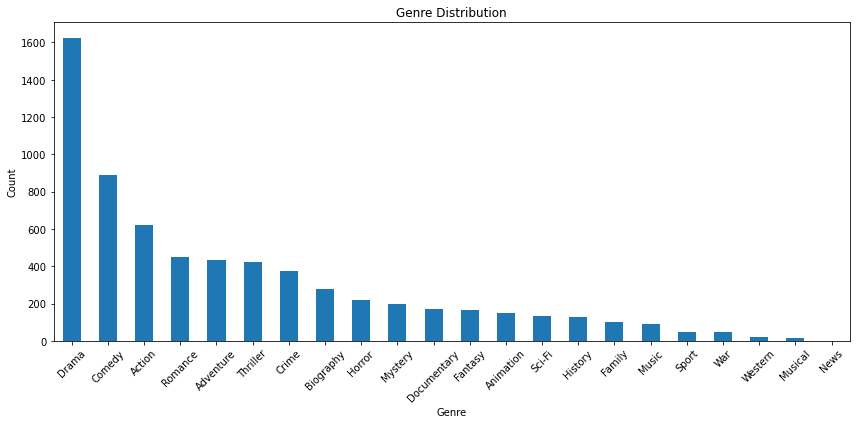

In [17]:
from collections import Counter
genre_list = df_combined['genres'].apply(lambda x: x.split(','))
genre_count = Counter([genre for sublist in genre_list for genre in sublist])

# Create DataFrame for plotting
df_genres = pd.DataFrame.from_dict(genre_count, orient='index', columns=['count'])

# Plot the genre distribution
plt.figure(figsize=(15, 10))
df_genres.sort_values('count', ascending=False).plot(kind='bar', legend=None, figsize=(12,6))
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 864x432 with 0 Axes>

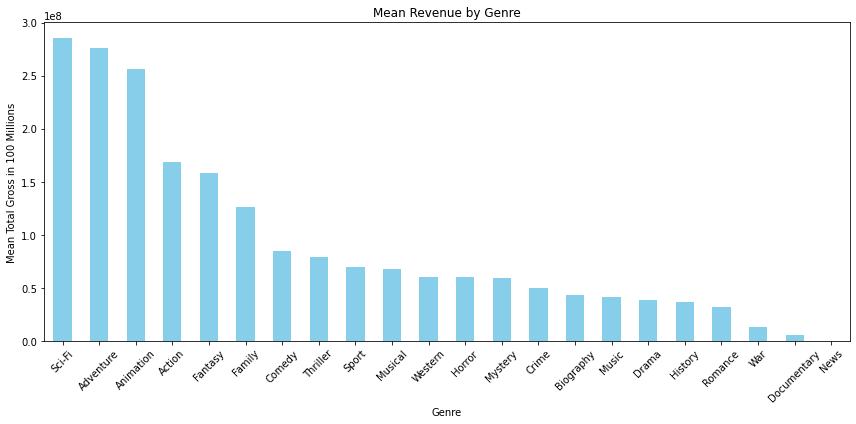

In [44]:
from collections import defaultdict
# Initialized defaultdicts to accumulate total gross and count for each genre
genre_revenue = defaultdict(float)
genre_count = defaultdict(int)

# Processed genres and accumulated total gross and count
for index, row in df_combined.iterrows():
    genres = row['genres'].split(',')
    total_gross = row['total_gross']
    for genre in genres:
        genre_revenue[genre] += total_gross
        genre_count[genre] += 1

# Calculated mean revenue for each genre
genre_mean_revenue = {genre: genre_revenue[genre] / genre_count[genre] for genre in genre_revenue}

# Created DataFrame for plotting
genre_mean_revenue_df = pd.DataFrame.from_dict(genre_mean_revenue, orient='index', columns=['mean_revenue'])

# Sorted by mean revenue
genre_mean_revenue_df = genre_mean_revenue_df.sort_values(by='mean_revenue', ascending=False)

# Plotted the genre distribution with mean revenue
plt.figure(figsize=(12, 6))
genre_mean_revenue_df.plot(kind='bar', legend=None, figsize=(12, 6), color='skyblue')
plt.title('Mean Revenue by Genre')
plt.xlabel('Genre')
plt.ylabel('Mean Total Gross in 100 Millions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
genre_mean_revenue_df

,mean_revenue
Sci-Fi,2.859181e+08
Adventure,2.758288e+08
Animation,2.567168e+08
Action,1.685909e+08
Fantasy,1.580287e+08
Family,1.265394e+08
Comedy,8.465291e+07
Thriller,7.916348e+07
Sport,6.923975e+07
Musical,6.776719e+07


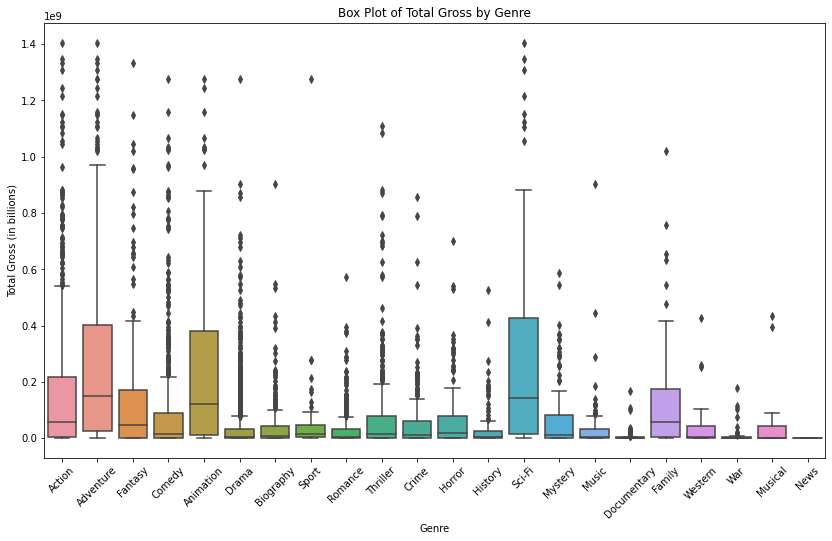

In [20]:
# Split genres into individual rows
df_genres = df_combined['genres'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).to_frame('genre')
df_genres = df_genres.join(df_combined[['primary_title', 'total_gross']], how='left')

# Plotted
plt.figure(figsize=(14, 8))
sns.boxplot(x='genre', y='total_gross', data=df_genres)
plt.xticks(rotation=45)
plt.title('Box Plot of Total Gross by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Gross (in billions)')
plt.show()

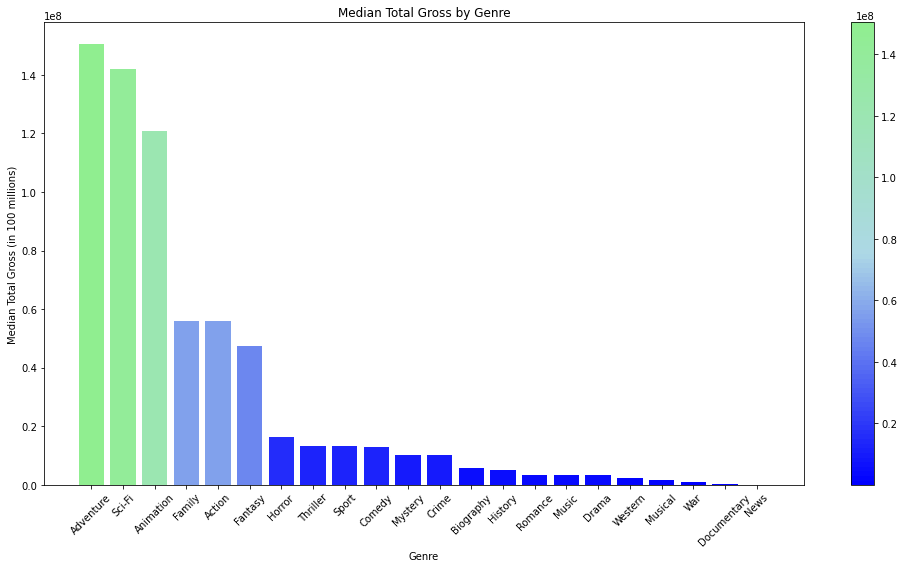

genre
Adventure     150400000
Sci-Fi        142150000
Animation     120900000
Family         56100000
Action         55788000
Fantasy        47450000
Horror         16400000
Thriller       13100000
Sport          13100000
Comedy         13067000
Mystery        10350000
Crime          10279750
Biography       5700000
History         5076000
Romance         3369000
Music           3325000
Drama           3200000
Western         2400000
Musical         1616000
War             1013000
Documentary      383000
News              13200
Name: total_gross, dtype: float64


In [43]:
from matplotlib.colors import LinearSegmentedColormap

# Calculated the median revenue for each genre
median_revenue = df_genres.groupby('genre')['total_gross'].median().sort_values(ascending=False)

# Defined a gradient color map
colors = [(0, "blue"), (0.5, "lightblue"), (1, "lightgreen")]
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'gradient'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Normalized data and created a gradient
norm = plt.Normalize(median_revenue.min(), median_revenue.max())
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])

# Plotting
plt.figure(figsize=(14, 8))
bars = plt.bar(median_revenue.index, median_revenue, color=cm(norm(median_revenue.values)))
plt.colorbar(sm)
plt.title('Median Total Gross by Genre')
plt.xlabel('Genre')
plt.ylabel('Median Total Gross (in 100 millions)')
plt.xticks(rotation=45)

# Setting y-tick labels to whole numbers
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))


plt.tight_layout()
plt.show()

print(median_revenue)

### Genre Conclusions
* Sci-Fi, Adventure and Animation made on average over 1 million more in total gross
* Sci-Fi despite being the 14th most common genre is the overall highest grossing genre on average
* Drama despite being by far the most common film made on average is the 17th highest grossing film
* The top three median genres are the same as the mean

In [22]:
df_grouped_by_genre = df_movie_rating.groupby('genres')['averagerating'].mean()
df_grouped_by_genre.sort_values(ascending=False).head(15)

genres
Adventure,Drama,War              8.900000
Documentary,Music,War            8.900000
Comedy,History,Musical           8.300000
Animation,History                8.300000
Romance,Thriller,War             8.200000
Comedy,Musical,Western           8.200000
Animation,Documentary,Mystery    8.200000
Animation,Crime,Mystery          8.200000
Documentary,Fantasy,Horror       8.200000
Animation,Fantasy,Mystery        8.000000
Comedy,Crime,Documentary         8.000000
Animation,Crime,Documentary      8.000000
Adventure,Documentary,History    7.966667
Documentary,Sport,Thriller       7.900000
Animation,Romance                7.900000
Name: averagerating, dtype: float64

## Release Dates
* Loaded in the Numbers data set and cleaned
* Plotted Mean Revenue by day of the year
* Compared release date to United States National Holidays

In [23]:
df_tn_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', compression='gzip')
df_tn_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [24]:
# Checked datatypes and non-null count for all columns, all are onject data types 
df_tn_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [25]:
# Created new dataframe with the numbers converted columns to float

df_tn_converted = df_tn_budgets.copy()
columns_to_convert = ['production_budget', 'domestic_gross', 'worldwide_gross']

# Made a funciton called columns_to_convert that removed $ and , from columns representing money
for column in columns_to_convert:
    df_tn_converted[column] = df_tn_converted[column].replace('[\$]','',regex=True)
    df_tn_converted[column] = df_tn_converted[column].replace('[,]','',regex=True).astype('float')

#Suppressed scientific notation, and checked datatype again. Used float64 as df was too large for integer Dtype 
pd.options.display.float_format = '{:.0f}'.format
print(df_tn_converted.dtypes)

id                     int64
release_date          object
movie                 object
production_budget    float64
domestic_gross       float64
worldwide_gross      float64
dtype: object


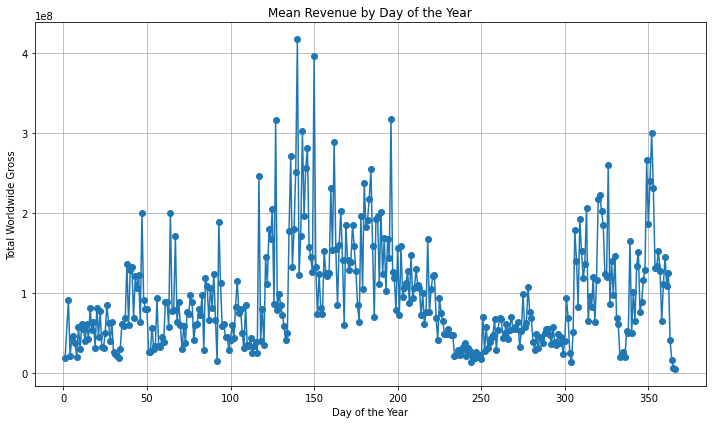

In [26]:
# Converted release_date to datetime format
df_tn_budgets['release_date'] = pd.to_datetime(df_tn_budgets['release_date'])

# Converted worldwide_gross to numeric, removing dollar signs and commas
df_tn_budgets['worldwide_gross'] = df_tn_budgets['worldwide_gross'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Extracted day of the year from release_date
df_tn_budgets['day_of_year'] = df_tn_budgets['release_date'].dt.dayofyear

# Grouped by day of the year and average worldwide_gross
daily_revenue = df_tn_budgets.groupby('day_of_year')['worldwide_gross'].mean().reset_index()

# Plotted the data with the day of the year as the x variable and average worldwide gross as the y value. 
plt.figure(figsize=(10, 6))
plt.plot(daily_revenue['day_of_year'], daily_revenue['worldwide_gross'], marker='o')
plt.title('Mean Revenue by Day of the Year')
plt.xlabel('Day of the Year')
plt.ylabel('Total Worldwide Gross')
plt.grid(True)
plt.tight_layout()

plt.show()

In [27]:
# Printed the top 15 days of the year
daily_revenue.sort_values(by='worldwide_gross', ascending=False).head(15)

,day_of_year,worldwide_gross
138,140,418237352
148,150,397331411
194,196,317770217
125,127,316343166
141,143,303055537
350,352,300566686
160,162,289453669
144,146,281566540
134,136,271290311
347,349,265947805


Compared the days with the highest mean worldwide gross to national holidays in the United States

Day 140: May 19 Close to Memorial Day (last Monday in May)\
Day 150: May 29 Close to Memorial Day (last Monday in May)\
Day 196: July 14 Close to Independence Day (July 4)\
Day 127: May 6 Close to Memorial Day (last Monday in May)\
Day 143: May 22 Close to Memorial Day (last Monday in May)\
Day 352: December 17 Close to Christmas (December 25)\
Day 162: June 10 Near Juneteenth (June 19th)\
Day 146: May 25 Close to Memorial Day (last Monday in May)\
Day 136: May 15 Close to Memorial Day (last Monday in May)\
Day 349: December 14 Close to Christmas (December 25)\
Day 326: November 21 Close to Thanksgiving (fourth Thursday in November)\
Day 145: May 24 Close to Memorial Day (last Monday in May)\
Day 184: July 2 Close to Independence Day (July 4)\
Day 139: May 18 Close to Memorial Day (last Monday in May)\
Day 117: April 26 No major U.S. holiday nearby

### Conclusion: 
* Films released around federal holidays appear to have the highest mean gross
* Summer and Winter movies have the highest mean revenue movie releases - possibly due to school being out
* Eight of the days with the highest mean occured in May
* Recommend releasing films in the summer or winter time for best return on investment

## Financially Successful Movies
* Created Financially Successful column using our definition of any movie making more than twice it's production budget 
* Checked percentage of total films that were successful
* Created scatterplot of financially successful vs unsuccessful films 
* Checked percentage of films that were successful based on a budget of budget over 1 million US dollars

In [28]:
# Approximately 45% of the films in our dataset were financially successful. 
df_tn_converted['financially_successful'] = df_tn_converted['worldwide_gross'] >= 2 * df_tn_converted['production_budget']
df_tn_converted['financially_successful'].value_counts()

False    3161
True     2621
Name: financially_successful, dtype: int64

In [29]:
# Converted release date to datetime format
df_tn_converted['release_date'] = pd.to_datetime(df_tn_converted['release_date'])

# Extracted day of the year
df_tn_converted['day_of_year'] = df_tn_converted['release_date'].dt.dayofyear

# Group by day of the year and calculate mean worldwide_gross
daily_mean_revenue = df_tn_converted.groupby('day_of_year')['worldwide_gross'].mean().reset_index()

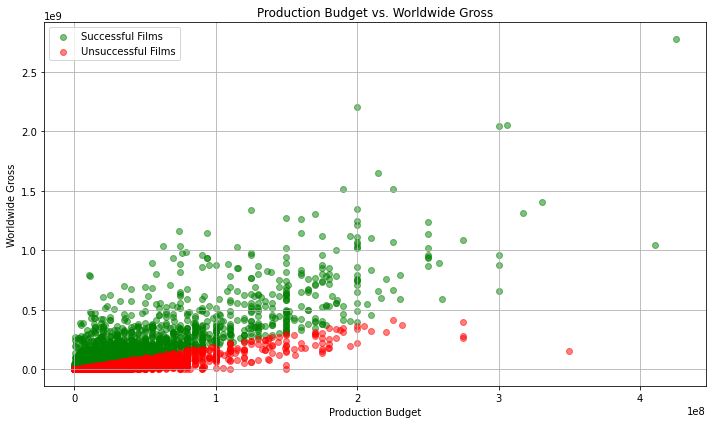

In [30]:
plt.figure(figsize=(10, 6))

# Plotted successful films
plt.scatter(
    df_tn_converted[df_tn_converted['financially_successful']]['production_budget'], 
    df_tn_converted[df_tn_converted['financially_successful']]['worldwide_gross'], 
    color='green', label='Successful Films', alpha=0.5)

# Plotted unsuccessful films
plt.scatter(
    df_tn_converted[~df_tn_converted['financially_successful']]['production_budget'], 
    df_tn_converted[~df_tn_converted['financially_successful']]['worldwide_gross'], 
    color='red', label='Unsuccessful Films', alpha=0.5)

# Titled and labeled graph
plt.title('Production Budget vs. Worldwide Gross')
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')
plt.legend()  # Added the legend
plt.grid(True)
plt.tight_layout()

# Displayed the plot
plt.show()

In [31]:
# Filtered the dataset for films with budgets over and under 1 million, 1 million chosen by observing the graph
over_500k = df_tn_converted[df_tn_converted['production_budget'] > 500_000]
under_500k = df_tn_converted[df_tn_converted['production_budget'] <= 500_000]

# Calculated the success rate for each group
success_rate_over_1m = over_500k['financially_successful'].mean() * 100
success_rate_under_1m = under_500k['financially_successful'].mean() * 100

print(f"Success Rate for Films with Budget Over 500,000: {success_rate_over_1m:.2f}%")
print(f"Success Rate for Films with Budget Under 500,000: {success_rate_under_1m:.2f}%")

Success Rate for Films with Budget Over 500,000: 45.89%
Success Rate for Films with Budget Under 500,000: 36.72%


In [32]:
# Filtered the dataset for films with budgets over and under 1 million, 1 million chosen by observing the graph
over_1m = df_tn_converted[df_tn_converted['production_budget'] > 1_000_000]
under_1m = df_tn_converted[df_tn_converted['production_budget'] <= 1_000_000]

# Calculated the success rate for each group
success_rate_over_1m = over_1m['financially_successful'].mean() * 100
success_rate_under_1m = under_1m['financially_successful'].mean() * 100

print(f"Success Rate for Films with Budget Over 1 Million: {success_rate_over_1m:.2f}%")
print(f"Success Rate for Films with Budget Under 1 Million: {success_rate_under_1m:.2f}%")

Success Rate for Films with Budget Over 1 Million: 46.41%
Success Rate for Films with Budget Under 1 Million: 35.49%


In [33]:
over_1500000m = df_tn_converted[df_tn_converted['production_budget'] > 1_500_000]
under_1500000m = df_tn_converted[df_tn_converted['production_budget'] <= 1_500_000]

# Calculated the success rate for each group
success_rate_over_1m = over_1500000m['financially_successful'].mean() * 100
success_rate_under_1m = under_1500000m['financially_successful'].mean() * 100

print(f"Success Rate for Films with Budget Over 1.5 Million: {success_rate_over_1m:.2f}%")
print(f"Success Rate for Films with Budget Under 1.5 Million: {success_rate_under_1m:.2f}%")

Success Rate for Films with Budget Over 1.5 Million: 46.80%
Success Rate for Films with Budget Under 1.5 Million: 35.00%


In [34]:
over_2m = df_tn_converted[df_tn_converted['production_budget'] > 2_000_000]
under_2m = df_tn_converted[df_tn_converted['production_budget'] <= 2_000_000]

# Calculated the success rate for each group
success_rate_over_1m = over_2m['financially_successful'].mean() * 100
success_rate_under_1m = under_2m['financially_successful'].mean() * 100

print(f"Success Rate for Films with Budget Over 2 Million: {success_rate_over_1m:.2f}%")
print(f"Success Rate for Films with Budget Under 2 Million: {success_rate_under_1m:.2f}%")

Success Rate for Films with Budget Over 2 Million: 47.07%
Success Rate for Films with Budget Under 2 Million: 35.83%


### Production Budget Conclusions
* Films with a production budget of over 500,000 were 45.89% likely to be successful
* Films with less than a 1 million dollar production budget dropped significantly to 35.49%
* Marginal success rate increase with every 500,000 increase in spending

# Overall Conclusion and Recommendations

* **A production budget of 1 million US dollars or more increases likelyhood of being financially successful**
    * Marginal increase in success rate with every increase of 500,000 investment
    * Films with a production budget over 1 million had over a 10% higher success rate than those below
    * 1 million is the value before returns significantly diminish or are negligable<br><br>
* **Summer or Winter Blockbusters - films released in Summer and Winter had highest average gross**
    * Possibly due to families being out of school<br>
    * Films released specifically in May made the most gross on average<br>
    * 14 of the top 15 film releases were around a United States federally recognized holiday<br><br>
       
* **Sci-Fi, Adventure, and Action - Only genres that make over 100,000,000 on avg**
    * The highest grossing on average films made on average a million more than films of other genres<br>
    * Sci-Fi and Animation movies are in the bottom ten most made genres but top 3 in average gross<br>
    
